# 1- Importing the Dependencies

In [183]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV ,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer ,CountVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression , Lasso
from sklearn.metrics import accuracy_score , classification_report , mean_squared_error,confusion_matrix,ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE


# 2- Training Data Collection 

In [2]:
df_train=pd.read_csv("train_data.txt",sep=":::",names=["ID","TITLE","GENRE","DESCRIPTION"],engine="python")

In [3]:
df_train.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


### Training Data preprocessing

In [4]:
df_train.isna().sum()

ID             0
TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

In [5]:
df_train.duplicated().sum()

0

In [6]:
df_train.drop(['ID'],axis=1,inplace=True)

In [7]:
df_train.head()

,TITLE,GENRE,DESCRIPTION
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [8]:
df_train.describe()

,TITLE,GENRE,DESCRIPTION
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


# 2- Testing Data Collection 

In [9]:
df_test=pd.read_csv("test_data.txt",sep=":::",names=["ID","GENRE","DESCRIPTION"],engine="python")

In [10]:
df_test.head()

,ID,GENRE,DESCRIPTION
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


###  Testing Data preprocessing

In [11]:
df_test.drop(['ID'],axis=1,inplace=True)

In [12]:
df_test.isna().sum()

GENRE          0
DESCRIPTION    0
dtype: int64

In [13]:
df_test.duplicated().sum()

0

In [14]:
df_test.shape

(54200, 2)

In [15]:
df_test.describe()

,GENRE,DESCRIPTION
count,54200,54200
unique,54200,54072
top,Edgar's Lunch (1998),Grammy - music award of the American academy ...
freq,1,10


## 3. Visualizing Target Variable.

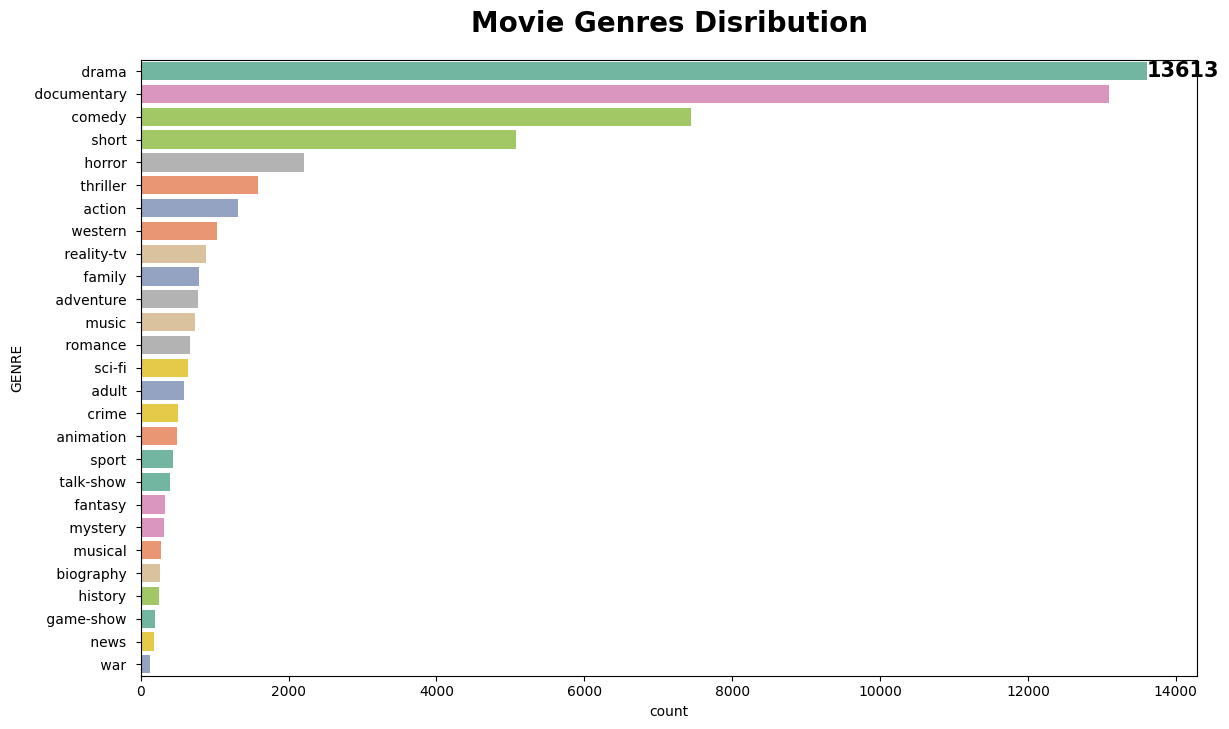

In [16]:
count = df_train["GENRE"].value_counts()

plt.figure(figsize=(30,8))
plt.subplot(1,2,1)
ax=sns.countplot(y ="GENRE" ,data = df_train , hue="GENRE",palette="Set2",order=count.index)
ax.bar_label(ax.containers[0],fontweight="black",size=15)
plt.title("Movie Genres Disribution",fontweight="black",size=20,pad=20)

plt.show()

# 4- Encoding Target Variable.

In [17]:
df_train['GENRE'].nunique()

27

In [18]:
df_train['GENRE'].unique()

array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

In [19]:
label_encoder = LabelEncoder()

df_train['GENRE_encoded'] = label_encoder.fit_transform(df_train['GENRE'])

In [20]:
df_train['GENRE_encoded'].unique()

array([ 8, 24,  1,  7,  5,  6, 18, 13, 22,  3,  0, 10, 21, 20, 14,  2, 23,
       26,  9, 16, 12, 17,  4, 19, 11, 15, 25])

In [21]:
df_train.sample(5)

,TITLE,GENRE,DESCRIPTION,GENRE_encoded
38069,Mengejar matahari (2004),drama,Mengejar Matahari is a coming of age tale of ...,8
36128,Rodney Perry Nothing But the Truth (2011),comedy,Rodney Perry's high energy brand of funny is ...,5
43189,Adventuress Wanted (2009),documentary,An American man and a Japanese woman leave fr...,7
38051,Broken Land (2014),documentary,"Out in desert-like nature, living in the shad...",7
45062,Roj (1966),drama,During turbulent times of the First Serbian u...,8


# 5-  cleaning data 

    1-Convert text to lowercase
    2-Remove special characters and numbers
    3-Remove punctuation
    4-Tokenize text
    5-Remove stopwords
    6-Remove multiple spaces


In [22]:
def data_preprocessing(text):
    
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = "".join([char for char in text if char not in string.punctuation])
    words = word_tokenize(text)
    text = " ".join([word for word in words if word not in stopwords.words("english") and len(word) > 2])
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [23]:
df_train['clean_description']=df_train['DESCRIPTION'].apply(data_preprocessing)
df_test['clean_description']=df_test['DESCRIPTION'].apply(data_preprocessing)

In [89]:
df_train.head()

,TITLE,GENRE,DESCRIPTION,GENRE_encoded,clean_description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,8,listening conversation doctor parents year old...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,24,brother sister past incestuous relationship cu...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,1,bus empties students field trip museum natural...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,8,help unemployed father make ends meet edith tw...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,8,film title refers recovered bodies ground zero...


In [88]:
df_test.head()

,GENRE,DESCRIPTION,clean_description
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherds north tra...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died spoken brother years serious cance...
4,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...


# 6- splitting features

In [152]:
y=df_train['GENRE_encoded']
x=df_train['clean_description']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [153]:
print("Shape of x_train is:",x_test.shape)
print("Shape of x_test is: ",x_train.shape)
print("Shape of y_train is:",y_train.shape)
print("Shape of y_test is: ",y_test.shape)

Shape of x_train is: (10843,)
Shape of x_test is:  (43371,)
Shape of y_train is: (43371,)
Shape of y_test is:  (10843,)


In [154]:
y_train.value_counts()

GENRE_encoded
8     10916
7     10437
5      6004
21     4028
13     1773
24     1282
0      1052
26      832
18      692
2       636
9       634
14      587
19      521
20      504
1       478
6       398
3       394
22      339
23      310
16      263
10      249
15      227
4       204
12      198
11      154
17      147
25      112
Name: count, dtype: int64

# 7- Feature Extraction


In [155]:
vectoriz=TfidfVectorizer(min_df=3, max_df=0.8, ngram_range=(1,2), max_features=5000)
x_train_tfidf = vectoriz.fit_transform(x_train)
x_test_tfidf = vectoriz.transform(x_test)

In [156]:
print("Shape of x_train after vectorization is:",x_train_tfidf.shape)
print("Shape of x_test after vectorization is:",x_test_tfidf.shape)

Shape of x_train after vectorization is: (43371, 5000)
Shape of x_test after vectorization is: (10843, 5000)


# 8- Applying SMOTE 

    to Overcome the Class-Imbalance in Target Variable.

In [157]:
smt = SMOTE(random_state=42)

x_train_resampled,y_train_resampled = smt.fit_resample(x_train_tfidf,y_train)

In [158]:
print("Shape of x_train after resampling is:",x_train_resampled.shape)
print("Shape of y_train after resampling is:",y_train_resampled.shape)

Shape of x_train after resampling is: (294732, 5000)
Shape of y_train after resampling is: (294732,)


In [159]:
y_train_resampled.value_counts()

GENRE_encoded
8     10916
3     10916
15    10916
17    10916
25    10916
1     10916
9     10916
22    10916
10    10916
16    10916
23    10916
19    10916
18    10916
20    10916
7     10916
11    10916
24    10916
6     10916
13    10916
2     10916
14    10916
0     10916
26    10916
4     10916
21    10916
5     10916
12    10916
Name: count, dtype: int64

# 9- Training the Model

In [193]:
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(x_train_resampled, y_train_resampled)

LogisticRegression(max_iter=5000)

In [194]:
acc_log = log_reg.score(x_train_resampled, y_train_resampled)
print("training Accuracy:", acc_log)

training Accuracy: 0.945825359988057


# 10- Evaluating the trained model


In [195]:
y_pred1 = log_reg.predict(x_test_tfidf)

In [197]:
accuracy_log = accuracy_score(y_test, y_pred1)
print("testing Accuracy:", accuracy_log)

testing Accuracy: 0.5147099511205386


In [198]:
print("Classification Report:")
print(classification_report(y_test, y_pred1))

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.44      0.38       263
           1       0.41      0.58      0.48       112
           2       0.15      0.27      0.20       139
           3       0.22      0.32      0.26       104
           4       0.04      0.07      0.05        61
           5       0.56      0.52      0.54      1443
           6       0.15      0.25      0.19       107
           7       0.78      0.65      0.71      2659
           8       0.68      0.49      0.57      2697
           9       0.13      0.27      0.18       150
          10       0.12      0.14      0.12        74
          11       0.70      0.70      0.70        40
          12       0.06      0.09      0.07        45
          13       0.58      0.66      0.62       431
          14       0.48      0.71      0.57       144
          15       0.16      0.26      0.20        50
          16       0.10      0.18      0.13        56
    